In [1]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image


# Visual Cryptography

The goal of this task is to split the image into 2 shares

Both of them should be cryptographically safe - from one share alone it should be impossible to recreate any information from the original image

In [2]:
image = np.array(Image.open("original.png"))[:,:,0]>250

Original image


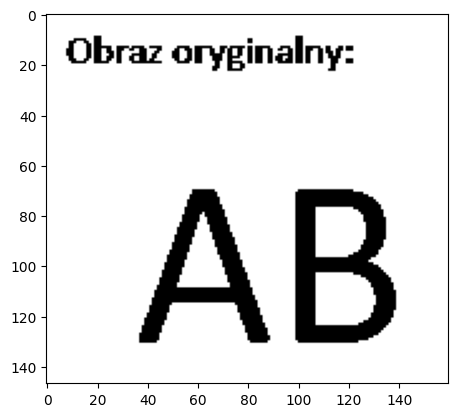

In [3]:
print("Original image")
plt.imshow(image,cmap='gray')

# Initial method

It's a known method, proven to solve the task by creating 2 safe shares

The size of a share has to be doubled because each 1x1 pixel is encoded as 2x2 tiles - the blocks.

The tiles are shown below

In [4]:
blocks = [np.array([[0,1],[1,0]],dtype=bool), np.array([[1,0],[0,1]],dtype=bool)]

<Figure size 640x480 with 0 Axes>

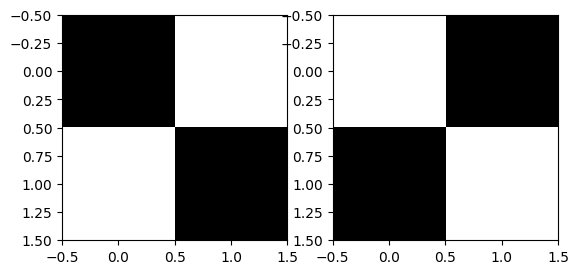

In [5]:
plt.figure()
f, ax = plt.subplots(1,2)
ax[0].imshow(blocks[0],cmap="gray")
ax[1].imshow(blocks[1],cmap="gray")

plt.show()

If the pixel in the image is white we randomly chose one tile to place in the share 1. The other tile is placed in share 2

If the pixel is black, we randomly chose a tile and place it on both shares.

(Note how the first share can be created without ever looking at the original image - we always chose a random tile and place it in share 1)

In [6]:
s = np.array(image.shape)*2

share_1_large = np.empty((s[0],s[1]))
share_2_large = np.empty((s[0],s[1]))

In [7]:
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        random_idx = np.random.choice([0,1])
        if image[i,j]:
            share_1_large[i*2:i*2+2, j*2:j*2+2] = blocks[random_idx]
            share_2_large[i*2:i*2+2, j*2:j*2+2] = blocks[1-random_idx]
        else:
            share_1_large[i*2:i*2+2, j*2:j*2+2] = blocks[random_idx]
            share_2_large[i*2:i*2+2, j*2:j*2+2] = blocks[random_idx]
            

This way we create two shares that have opposite tiles in the positions where the pixels in original image are white

<Figure size 640x480 with 0 Axes>

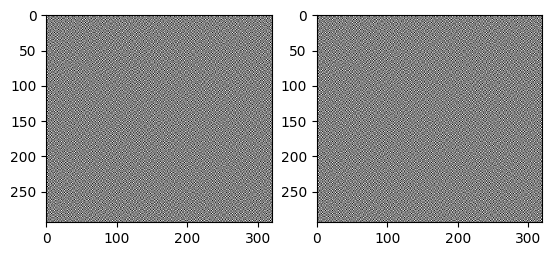

In [8]:
plt.figure()
f, ax = plt.subplots(1,2)
ax[0].imshow(share_1_large,cmap="gray")
ax[1].imshow(share_2_large,cmap="gray")

plt.show()

We can read the original by performing the or operation

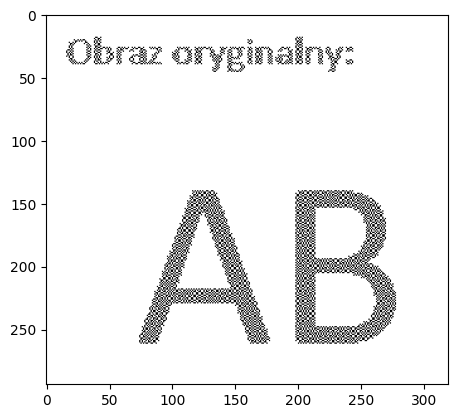

In [9]:
plt.imshow(np.logical_or(share_1_large,share_2_large),cmap='gray')

We were able to retrieve the information from the original image. But as it turns out there's an equivalent way of solving this task.

---

# xor and downsizing analysis

What if we replace or with xor?

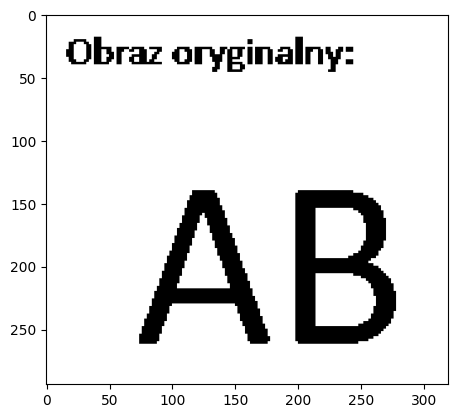

In [10]:
plt.imshow(np.logical_xor(share_1_large,share_2_large),cmap='gray')

Apparently xor works better. But an idea comes to mind. If the two shares are safe, why not downsize them and replace the first tile with 0 and the 2nd with 1?

In [11]:
share_1_small = np.full(image.shape, False)
share_2_small = np.full(image.shape, False)

block_to_encode = np.random.choice([0,1]) # it doesn't matter which block is encoded as 0 and which as 1

In [12]:
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        if np.all(share_1_large[i*2:i*2+2, j*2:j*2+2] == blocks[block_to_encode]):
            share_1_small[i,j] = True
        if np.all(share_2_large[i*2:i*2+2, j*2:j*2+2] == blocks[block_to_encode]):
            share_2_small[i,j]  = True

<Figure size 640x480 with 0 Axes>

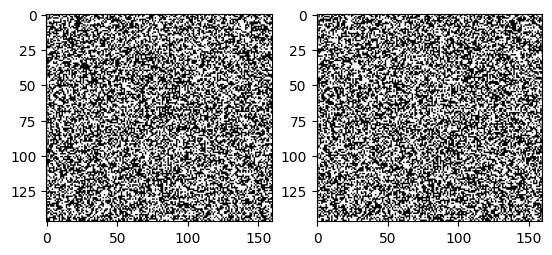

In [13]:
plt.figure()
f, ax = plt.subplots(1,2)
ax[0].imshow(share_1_small,cmap="gray")
ax[1].imshow(share_2_small,cmap="gray")

plt.show()

We downsized the 2 shares. We can see that using xor can return the secret!

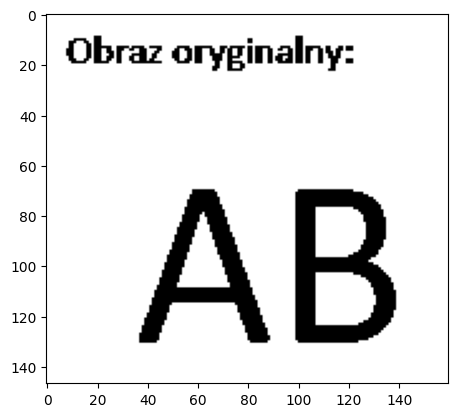

In [14]:
plt.imshow(np.logical_xor(share_1_small,share_2_small),cmap='gray')

In [15]:
np.all(np.logical_xor(share_1_small,share_2_small) == image)

True

As it turns out we can still get the original image by downsizing the share!

# Better method

What if we want to skip the step of creating a pair of shares with doubled size?

Remember how we noticed that the first share was created by randomly choosing one of the tiles? 

We could have created it as the small version from the start by choosing random pixel(black or white)

In [16]:
share_1 = np.random.choice([False, True], size=image.shape)

Notice how the other share has a tile opposite to the first one at positions where the pixels in the original image are white. 

It means that the small share 2, on those positions has opposite pixels to small share 2. We can create that by simply performing xor with original image

In [17]:
share_2 = np.logical_xor(image,share_1)

<Figure size 640x480 with 0 Axes>

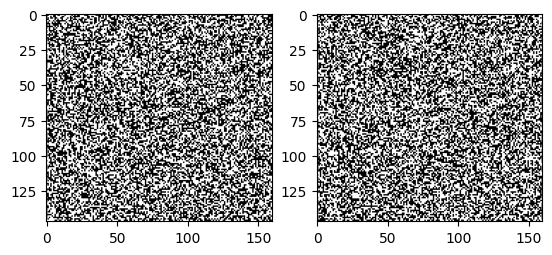

In [18]:
plt.figure()
f, ax = plt.subplots(1,2)
ax[0].imshow(share_1,cmap="gray")
ax[1].imshow(share_2,cmap="gray")

plt.show()

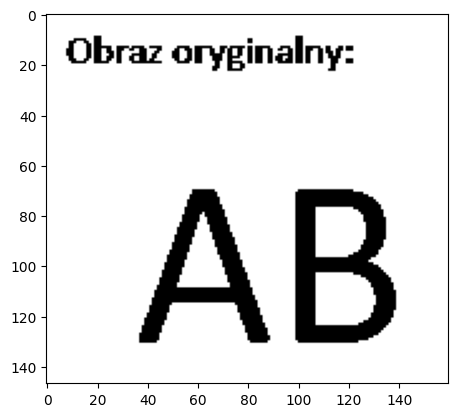

In [19]:
plt.imshow(np.logical_xor(share_1,share_2),cmap='gray')

As it turns out we can simplify the original process to performing a xor operation with a random image. If this process was unsafe it would mean that the original process is also unsafe (we would be able to reduce it to the new one by simply converting the secret's tiles to pixels like we did a few cells above)

# Generalization

### We can generalize this process to images in grayscale

In [20]:
image_grayscale = np.array(Image.open("band.jpg").convert('L'))

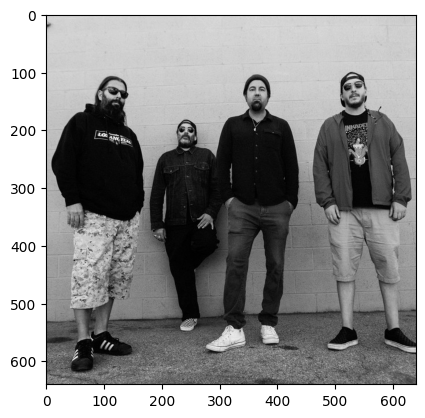

In [21]:
plt.imshow(image_grayscale,cmap="gray")

In [22]:
def encode_grayscale(image):
    share_1 = np.random.randint(256,size=image.shape,dtype=np.uint8)
    share_2 = np.bitwise_xor(share_1,image)
    return share_1, share_2

def decode_grayscale(share_1,share_2):
    return np.bitwise_xor(share_1,share_2)

<Figure size 640x480 with 0 Axes>

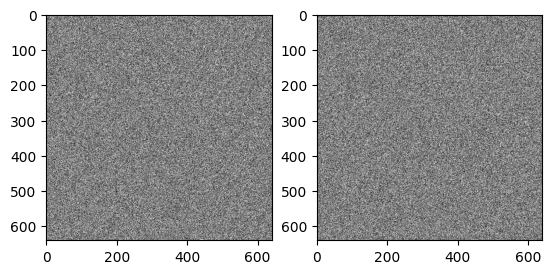

In [23]:
share_1, share_2 = encode_grayscale(image_grayscale)

plt.figure()
f, ax = plt.subplots(1,2)
ax[0].imshow(share_1,cmap="gray")
ax[1].imshow(share_2,cmap="gray")

plt.show()

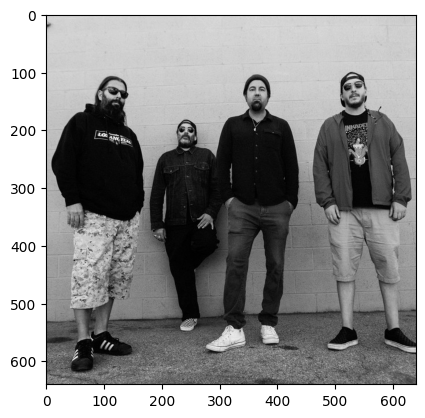

In [24]:
plt.imshow(decode_grayscale(share_1,share_2),cmap='gray')

### Colors work great as well!

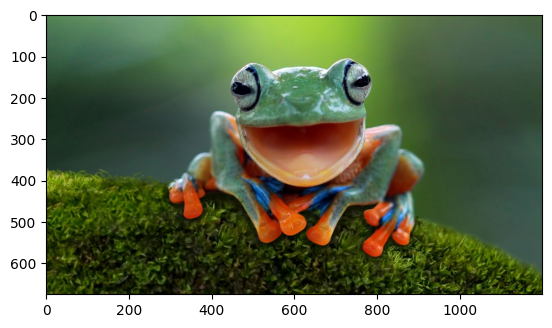

In [25]:
image_color = np.array(Image.open("frog.jpg"))
plt.imshow(image_color, cmap="gray")

In [26]:
def encode_color(image):
    r1,r2 = encode_grayscale(image[:,:,0])
    g1,g2 = encode_grayscale(image[:,:,1])
    b1,b2 = encode_grayscale(image[:,:,2])
    
    return np.stack([r1,g1,b1]).transpose((1,2,0)), np.stack([r2,g2,b2]).transpose((1,2,0))
    

def decode_color(share_1,share_2):
    r = decode_grayscale(share_1[:,:,0],share_2[:,:,0])
    g = decode_grayscale(share_1[:,:,1],share_2[:,:,1])
    b = decode_grayscale(share_1[:,:,2],share_2[:,:,2])
    return np.stack([r,g,b]).transpose((1,2,0))
    

<Figure size 640x480 with 0 Axes>

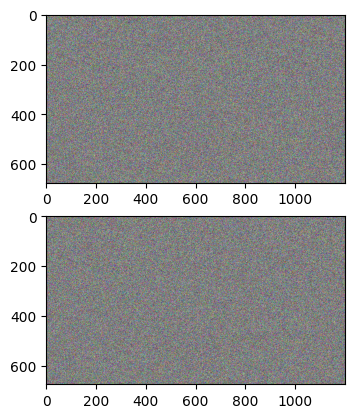

In [27]:
share_1, share_2 = encode_color(image_color)

plt.figure()
f, ax = plt.subplots(2)
ax[0].imshow(share_1,cmap="gray")
ax[1].imshow(share_2,cmap="gray")

plt.show()

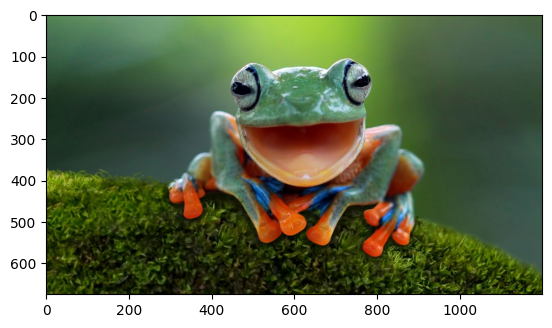

In [28]:
plt.imshow(decode_color(share_1,share_2),cmap='gray')

### The best part? We can generalize to multiple shares that return the secret only when we combine all of them!

With this approach the order of encoding and decoding won't matter. We only need to xor all of the shares together

<Figure size 640x480 with 0 Axes>

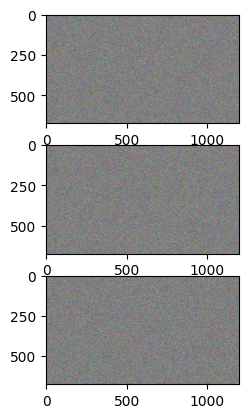

In [29]:
share_1, share_2 = encode_color(image_color)
share_2, share_3 = encode_color(share_2)

plt.figure()
f, ax = plt.subplots(3)
ax[0].imshow(share_1,cmap="gray")
ax[1].imshow(share_2,cmap="gray")
ax[2].imshow(share_3,cmap="gray")

plt.show()

The shares won't return the image if we don't have all of them

<Figure size 640x480 with 0 Axes>

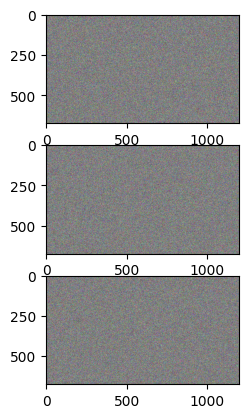

In [30]:
plt.figure()
f, ax = plt.subplots(3)
ax[0].imshow(decode_color(share_1,share_2),cmap="gray")
ax[1].imshow(decode_color(share_1,share_3),cmap="gray")
ax[2].imshow(decode_color(share_2,share_3),cmap="gray")

plt.show()

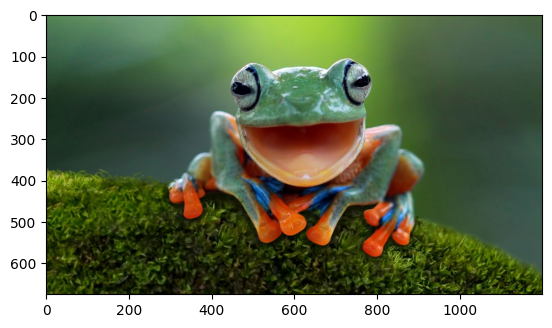

In [31]:
share_ = decode_color(share_1,share_3)
decoded_image = decode_color(share_2,share_)

plt.imshow(decoded_image,cmap='gray')